# EII Client Tutorial

This notebook introduces the core `eii.client` interfaces for querying point values, polygon summaries, and raster exports.
Most workflows use pre-computed global layers (fast, low cost), while on-the-fly mode is useful for experimenting with methods.
All client functions accept `ee`, `GeoPandas`, `shapely` geometries, or bbox tuples.


## Core functions at a glance

- `get_stats`: point values or polygon summary stats; use `compute_mode="precomputed"` for production and `"on_the_fly"` for method exploration.
- `get_zonal_stats`: batch stats over many polygons (FeatureCollection/GeoDataFrame).
- `get_raster`: export rasters in memory or GeoTIFF, with auto chunking for large AOIs.
- `get_layers`: access the underlying Earth Engine image stack for custom GEE workflows.

## Setup

In [4]:
import ee
import geemap
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
from shapely.geometry import Polygon

from eii.client import get_layers, get_raster, get_stats, get_zonal_stats, quicklook

ee.Authenticate()
ee.Initialize()

## Point query

Fetch EII and component values at a single location.

In [2]:
lat = 47.3769
lon = 8.5417
point = ee.Geometry.Point([lon, lat])

point_stats = get_stats(
    point,
    include_components=True,
    compute_mode="on_the_fly",
    output_format="dict",
)
point_stats

{'geometry_type': 'Point',
 'values': {'eii': 0.013174429804471451,
  'functional_integrity': 0.3766448455258405,
  'structural_integrity': 0.022896040230989456,
  'compositional_integrity': 0.3188507556915283}}

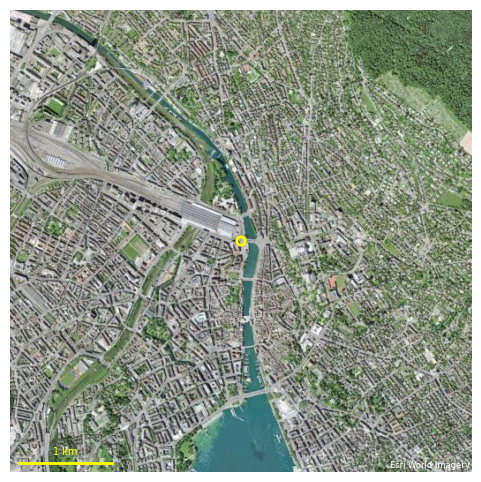

In [3]:
_ = quicklook(point, min_bbox_km=5, layer_color="yellow")

## Polygon query

Compute summary statistics for a polygon AOI using precomputed layers.

In [ ]:
gdf = gpd.read_file("data/aoi.geojson")
polygon_stats = get_stats(
    gdf,
    include_components=True,
    compute_mode="precomputed",
    output_format="geodataframe",
    stats=["mean", "std"],
)
polygon_stats

eii           functional_integrity           structural_integrity  \
       mean       std                 mean       std                 mean   
0  0.347932  0.022563             0.421876  0.027854              0.49594   

            compositional_integrity            \
        std                    mean       std   
0  0.037167                0.650754  0.061209   

                                            geometry  
                                                      
0  POLYGON ((10.70566 47.70138, 10.71006 47.71096...

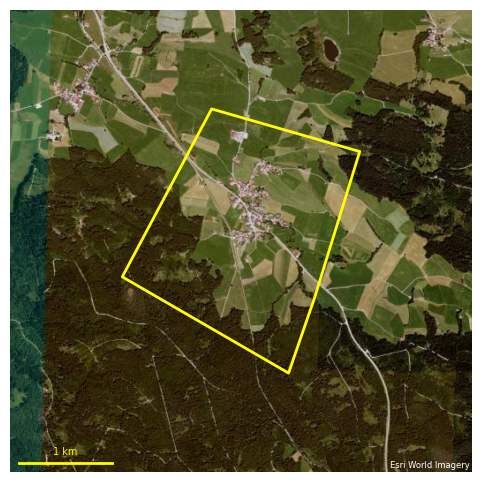

In [5]:
_ = quicklook(polygon_geom, min_bbox_km=5)

## Zonal stats for multiple polygons

Compute summary statistics over a FeatureCollection (e.g., buffered cities).

In [6]:
site = pd.DataFrame(
    {
        "city": ["Munich, Germany", "Davos, Switzerland", "Amazonas, Brazil"],
        "lat": [48.1426428, 46.8025, -6.6520],
        "lon": [11.5650141, 9.8355, -67.0986],
    }
)

points = gpd.GeoDataFrame(
    site,
    geometry=gpd.points_from_xy(site["lon"], site["lat"]),
    crs="EPSG:4326",
).drop(columns=["lon", "lat"])

points_m = points.to_crs("EPSG:3857")
buffers_m = points_m.copy()
buffers_m["geometry"] = points_m.geometry.buffer(1000)

buffers = buffers_m.to_crs("EPSG:4326")
city_fc = geemap.geopandas_to_ee(buffers)

stats_fc = get_zonal_stats(
    city_fc,
    include_components=True,
    compute_mode="precomputed",
    keep_columns=["city"],
    stats=["min", "mean", "max"],
    percentiles=[10, 90],
)
stats_fc

city compositional_integrity                                \
                value                     max      mean       min       p10   
0     Munich, Germany                0.340276  0.315115  0.283948  0.287427   
1  Davos, Switzerland                0.809536  0.715927  0.644848  0.647543   
2    Amazonas, Brazil                0.999999  0.999999  0.999999  0.999999   

                  eii                                ... functional_integrity  \
        p90       max      mean       min       p10  ...                 mean   
0  0.332552  0.000341  0.000001  0.000000  0.000000  ...             0.386136   
1  0.780082  0.579297  0.550467  0.370845  0.548049  ...             0.732485   
2  0.999999  0.894185  0.880734  0.865208  0.868786  ...             0.880734   

                                structural_integrity                      \
        min       p10       p90                  max      mean       min   
0  0.357504  0.360737  0.407177             0.000570  0.000002  0.000000   
1  0.399755  0.609896  0.810844             0.620296  0.601744  0.594926   
2  0.865208  0.868786  0.886895             1.000000  1.000000  1.000000   

                                                                geometry  
        p10       p90                                                     
0  0.000000  0.000000  POLYGON ((11.574 48.14264, 11.57395 48.14323, ...  
1  0.595211  0.608894  POLYGON ((9.84448 46.8025, 9.84444 46.8031, 9....  
2  1.000000  1.000000  POLYGON ((-67.08962 -6.652, -67.08966 -6.65113...  

[3 rows x 22 columns]

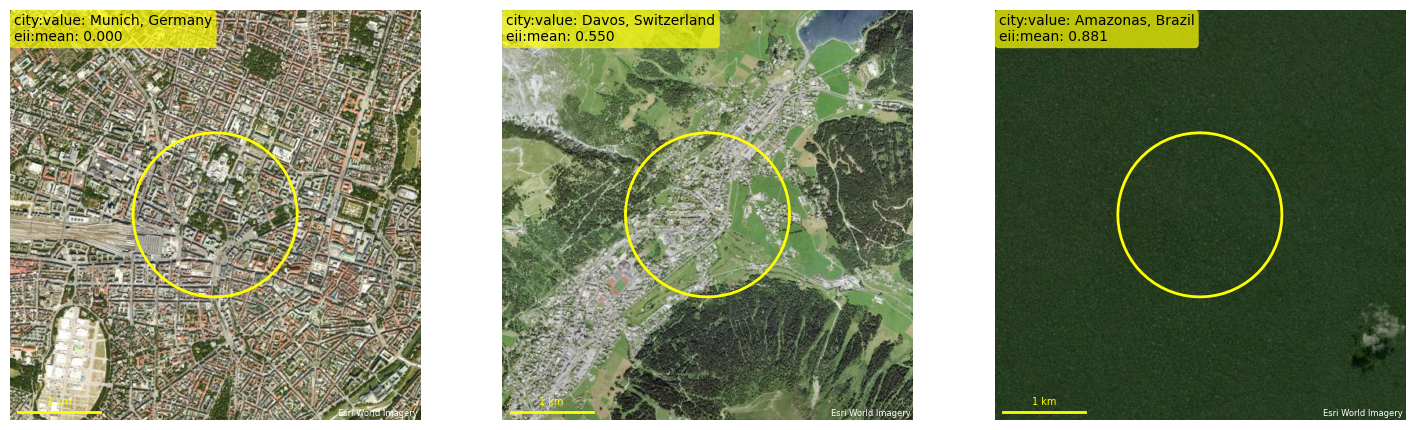

In [7]:
fig, ax = quicklook(
    stats_fc, min_bbox_km=5, layer_color="yellow", overlay_fields=["city:value", "eii:mean"]
)
fig.savefig("figures/quicklook_eii_stats.png", dpi=300, transparent=True, bbox_inches="tight")

## Raster access

Retrieve full rasters either in memory (xarray) or on disk (GeoTIFF).

In [8]:
rasters = get_raster(
    polygon_geom,
    chunking="auto",
    output_format="memory",
    include_components=False,
)
rasters

<xarray.Dataset> Size: 696B
Dimensions:  (x: 10, y: 7)
Coordinates:
  * x        (x) float64 80B 10.69 10.69 10.69 10.69 ... 10.7 10.71 10.71 10.71
  * y        (y) float64 56B 47.71 47.71 47.71 47.7 47.7 47.7 47.7
Data variables:
    eii      (y, x) float64 560B 0.3233 0.3291 0.3426 ... 0.3619 0.3542 0.3583
Attributes:
    crs:         EPSG:4326
    transform:   (0.0026949458523585646, 0.0, 10.685460304601708, 0.0, -0.002...
    resolution:  (0.0026949458523585646, -0.0026949458523585646)
    eii_method:  min_fuzzy_logic
    scale_m:     300
    area_sq_km:  3.3195098052892082

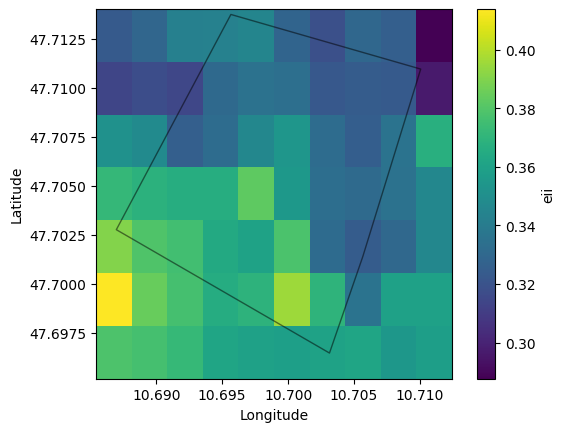

In [9]:
img = rasters.eii.plot.imshow()
ax = img.axes
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
_ = gdf.plot(ax=ax, color="none", edgecolor="black", alpha=0.5)

### GeoTIFF export and lazy loading

Define a small AOI, stream a single GeoTIFF, then open it lazily with dask via `rioxarray`.

In [10]:
coords = [
    (-105.24, 40.505),
    (-104.94, 40.505),
    (-104.94, 40.705),
    (-105.24, 40.705),
    (-105.24, 40.505),
]

aoi = gpd.GeoDataFrame(geometry=[Polygon(coords)], crs="EPSG:4326")

In [11]:
geotiff_path = get_raster(
    aoi,
    chunking="auto",
    output_format="geotiff",
    out_path="/tmp/eii_aoi.tif",
)
geotiff_path

PosixPath('/tmp/eii_aoi.tif')

In [12]:
lazy_rasters = rxr.open_rasterio(geotiff_path, chunks="auto", engine="rasterio")
names = list(lazy_rasters.attrs["long_name"])
lazy_rasters = lazy_rasters.assign_coords(band=names).to_dataset(dim="band")
lazy_rasters

<xarray.Dataset> Size: 274kB
Dimensions:                  (y: 76, x: 112)
Coordinates:
  * y                        (y) float64 608B 40.71 40.7 40.7 ... 40.51 40.5
  * x                        (x) float64 896B -105.2 -105.2 ... -104.9 -104.9
    spatial_ref              int64 8B 0
Data variables:
    eii                      (y, x) float64 68kB dask.array<chunksize=(76, 112), meta=np.ndarray>
    functional_integrity     (y, x) float64 68kB dask.array<chunksize=(76, 112), meta=np.ndarray>
    structural_integrity     (y, x) float64 68kB dask.array<chunksize=(76, 112), meta=np.ndarray>
    compositional_integrity  (y, x) float64 68kB dask.array<chunksize=(76, 112), meta=np.ndarray>
Attributes:
    resolution:     (0.0026949458523585646, -0.0026949458523585646)
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('eii', 'functional_integrity', 'structural_integrity', '...

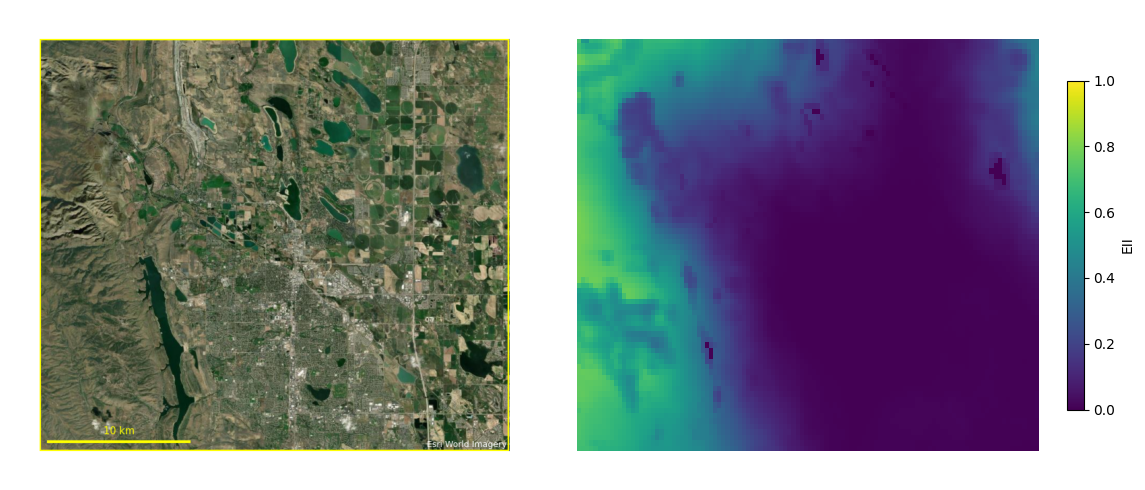

In [13]:
import io

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [1, 1]})

quicklook_fig, _ = quicklook(aoi, min_bbox_km=10, layer_color="yellow")
buf = io.BytesIO()
quicklook_fig.savefig(
    buf,
    format="png",
    dpi=150,
    bbox_inches="tight",
    pad_inches=0.29,
)
plt.close(quicklook_fig)
buf.seek(0)
img = plt.imread(buf)
axes[0].imshow(img)
axes[0].axis("off")

ax_img = lazy_rasters.eii.plot.imshow(
    ax=axes[1],
    vmin=0,
    vmax=1,
    cbar_kwargs={"shrink": 0.7, "label": "EII"},
)
ax = ax_img.axes
ax.set_title(None)
lat0 = float(lazy_rasters.y.mean())
ax.set_aspect(1 / np.cos(np.deg2rad(lat0)))
ax.set_axis_off()
fig.tight_layout()

## Server-side image stack

Get the underlying Earth Engine objects for downstream GEE workflows.

In [14]:
layers = get_layers(
    layers="all",
    aggregation_method="min_fuzzy_logic",
    compute_mode="precomputed",
    geometry=polygon_geom,
)
layers

{'functional': <ee.image.Image at 0x7f899d012960>,
 'structural': <ee.image.Image at 0x7f899d012ab0>,
 'compositional': <ee.image.Image at 0x7f899d013830>,
 'eii': <ee.image.Image at 0x7f899d012db0>}